In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# A look at the data 

In [6]:
# import deaths data
df_deaths = pd.read_csv("../data/new_covid19_deaths_italy.csv")
df_deaths["new_deaths"] = df_deaths["total_deaths"].diff()
df_deaths = df_deaths.loc[(df_deaths.date >= "2020-02-25") & (df_deaths.date <= "2020-08-01")]
df_deaths["date"] = pd.to_datetime(df_deaths.date)
df_deaths.head()

,date,total_deaths,new_cases,tests,new_deaths
1,2020-02-25,10,93,8623,3.0
2,2020-02-26,12,78,9587,2.0
3,2020-02-27,17,250,12014,5.0
4,2020-02-28,21,238,15695,4.0
5,2020-02-29,29,240,18661,8.0


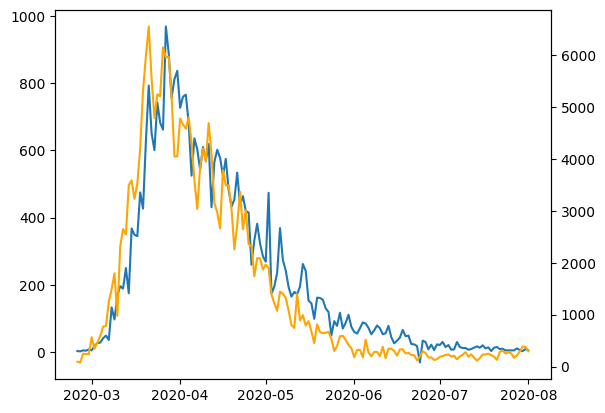

In [8]:
# plot deaths and cases
fig, ax = plt.subplots()
ax.plot(df_deaths.date, df_deaths.new_deaths)

ax2 = ax.twinx()
ax2.plot(df_deaths.date, df_deaths.new_cases, color="orange")

In [ ]:
# plot tests

In [ ]:
# import google mobility data

In [ ]:
# plot google mobility data for Italy

In [ ]:
# plot google mobility data for each region

# Modeling

In [ ]:
def get_beta(R0, mu, contact_matrix, Nk): 
    contact_matrix_weighted = contact_matrix.copy()
    for i in range(contact_matrix.shape[0]):
        for j in range(contact_matrix.shape[1]):
            contact_matrix_weighted[i,j] = contact_matrix[i,j] * Nk[i] / Nk[j]

    rho = np.linalg.eigvals(contact_matrix_weighted).real.max()
    return R0 / rho * mu

def stochastic_seirD_age_structure(R0, 
                                   eps,
                                   mu, 
                                   C, 
                                   Nk, 
                                   I0_perc, 
                                   T, 
                                   reductions, 
                                   ifr, 
                                   Delta):
    """
    Function to simulate the stochastic SIR model with age structure.

    Parameters:
        R0 (float): Basic reproduction number
        eps (float): Inverse of of Incubation period 
        mu (float): Recovery rate
        C (array): Contact matrix
        Nk (array): Total population size by age group
        I0_perc (float): Fraction of number of infected individuals
        T (int): number of steps to simulate
        reductions (array): Array of reductions in contacts
        ifr (array): Infection fatality rate
        Delta (float): deaths delay

    Returns:
        S (array): Array of susceptible individuals over time and age groups
        E (array): Array of susceptible individuals over time and age groups
        I (array): Array of infected individuals over time and age groups
        R (array): Array of recovered individuals over time and age groups
        D (array): Array of deaths over time and age groups
    """

    I0 = int(Nk.sum() * I0_perc)   # initial number of infected individuals
    nage = len(C)                  # number of age groups
    S, E, I, R = np.zeros((T, nage)), np.zeros((T, nage)), np.zeros((T, nage)), np.zeros((T, nage))
    D0, D1, D2 = np.zeros((T, nage)), np.zeros((T, nage)), np.zeros((T, nage))

    # compute beta 

    # initialize compartments
    

    # simulate


    return dict(S=np.array(S), 
                E=np.array(E), 
                I=np.array(I), 
                R=np.array(R), 
                D0=np.array(D0), 
                D1=np.array(D1),
                D2=np.array(D2))


In [ ]:
# import population and contact matrix

In [ ]:
# infection fatality rate (Verity et al)
ifr = [0.00161 / 100, # 0-4
        0.00161 / 100, # 5-9
        0.00695 / 100, # 10-14
        0.00695 / 100, # 15-19
        0.0309  / 100, # 20-24
        0.0309  / 100, # 25-29
        0.0844  / 100, # 30-34
        0.0844  / 100, # 35-39
        0.161   / 100, # 40-44
        0.161   / 100, # 45-49
        0.595   / 100, # 50-54
        0.595   / 100, # 55-59
        1.93    / 100, # 60-64
        1.93    / 100, # 65-69
        4.28    / 100, # 70-74
        6.04    / 100] # 75+

In [ ]:
# run model for random set of parameters

In [ ]:
# plot new deaths 

In [ ]:
# plot new deaths for each age group

# Calibration

In [ ]:
import pyabc
import uuid
from pyabc.sampler import MulticoreEvalParallelSampler
from pyabc import RV, Distribution, MultivariateNormalTransition, AggregatedTransition
import os
import pickle as pkl

def wmape_pyabc(sim_data, actual_data):
    return np.sum(np.abs(actual_data['data'] - sim_data['data'])) / np.sum(np.abs(actual_data['data']))
    
def compute_quantiles(samples: np.ndarray, quantiles: np.ndarray = np.arange(0.01, 1.0, 0.01)) -> pd.DataFrame:
    df_samples = pd.DataFrame() 
    for q in quantiles:
        df_samples[str(np.round(q, 2))] = np.quantile(samples, axis=0, q=np.round(q, 2))
    
    # additional quantiles and aggregated measures
    df_samples["0.025"] = np.quantile(samples, axis=0, q=0.025)
    df_samples["0.975"] = np.quantile(samples, axis=0, q=0.975)
    df_samples["min"] = np.min(samples, axis=0)
    df_samples["max"] = np.max(samples, axis=0)
    return df_samples

def calibration(epimodel, 
                prior, 
                params, 
                distance,
                observations,
                transitions,
                simulation_dates,
                population_size : int = 1000,
                minimum_epsilon : float = 0.3, 
                max_nr_populations : int = 10, 
                n_procs : int = 8, 
                filename : str = '', 
                folder_name : str = "calibration_runs"):

    """
    Run ABC calibration on given model and prior 
    Parameters
    ----------
        @param epimodel (Callable): epidemic model 
        @param prior (pyabc.Distribution): prior distribution
        @param params (dict): dictionary of fixed parameters value
        @param distance (Callable): distance function to use 
        @param observations (List[float]): real observations 
        @param transitions (pyabc.AggregatedTransition): next gen. perturbation transitions
        @param population_size (int): size of the population of a given generation
        @param minimum_epsilon (float): minimum tolerance (if reached calibration stops)
        @param max_nr_population (int): maximum number of generations
        @param filename (str): name of the files used to store ABC results
        @param folder_name (str): name of the folder where ABC results are stored
    Returns
    -------
        @return: returns ABC history
    """


    def make_model(epimodel, param): 
        def model(p): 
            # run model 
            results = epimodel(**p, **param)
            return {'data': np.diff(np.sum(results["D2"], axis=1))}
        return model

    if filename == '':
        filename = str(uuid.uuid4())

    abc = pyabc.ABCSMC(make_model(epimodel, params), 
                       prior, 
                       distance, 
                       transitions=transitions, 
                       population_size=population_size,
                       sampler=MulticoreEvalParallelSampler(n_procs=n_procs))
    
    db_path = os.path.join(f'./{folder_name}/dbs/', f"{filename}.db")
    abc.new("sqlite:///" + db_path, {"data": observations})
    history = abc.run(minimum_epsilon=minimum_epsilon, 
                      max_nr_populations=max_nr_populations)
    
    with open(os.path.join(f'./{folder_name}/abc_history/', f"{filename}.pkl"), 'wb') as file:
        pkl.dump(history, file)

    # save posterior distribution
    history.get_distribution()[0].to_csv(os.path.join(f"./{folder_name}/posteriors/", f"{filename}_posterior_distributions.csv"))  

    # compute quantiles and save samples
    raw_samples = np.array([d["data"] for d in history.get_weighted_sum_stats()[1]])
    df_samples = compute_quantiles(raw_samples)
    df_samples["date"] = simulation_dates
    df_samples["data"] = history.observed_sum_stat()["data"]
    df_samples.to_csv(os.path.join(f"./{folder_name}/posteriors/", f"{filename}_posterior_quantiles.csv"), index=False)  
    np.savez_compressed(os.path.join(f"./{folder_name}/posteriors/", f"{filename}_posterior_samples.npz"), raw_samples)

    return history, abc

In [ ]:
calibration(epimodel=stochastic_seirD_age_structure, 
            prior=Distribution(R0=RV("uniform", 1.8, 4.0 - 1.8), 
                               I0_perc=RV("uniform", 0.01 / 100., 0.5 / 100. - 0.01 / 100.), 
                               Delta=RV("uniform", 7., 28. - 7.)), 
            params=dict(eps=1./4.,
                        mu=1./2.5, 
                        C=C_ita, 
                        Nk=pop_ita.Value.values, 
                        T=len(simulation_dates), 
                        reductions=((1 + df_google_ita["reduction"]/100)**2).values, 
                        ifr=ifr), 
            distance=wmape_pyabc,
            observations=df_deaths.new_deaths.values[1:],
            transitions=AggregatedTransition(mapping=dict(R0=MultivariateNormalTransition(),
                                                          I0_perc=MultivariateNormalTransition(),
                                                          Delta=MultivariateNormalTransition())),
            simulation_dates=df_deaths.new_deaths.values[1:])

In [ ]:
# plot sampled deaths

In [ ]:
# plot posterior distributions